##Import relevant libararies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

##Loading the data

In [4]:
from google.colab import files
uploaded = files.upload() # upload kaggle.json
'''
if don't have your kaggle.json file
please go to your kaggle profile-> settings-> API -> create API token
then run this cell for once
'''
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
from pathlib import Path
import zipfile
import pandas as pd

def download_diamonds_data():
  ! kaggle competitions download -c diamond-price-prediciton-2024
  zip_path = Path("diamond-price-prediciton-2024.zip")
  with zipfile.ZipFile(zip_path) as diamonds_zip:
    diamonds_zip.extractall()

  diamonds_train = pd.read_csv(Path('train.csv'),index_col=0)
  diamonds_test = pd.read_csv(Path('test.csv'),index_col=0)
  return diamonds_train , diamonds_test
diamonds_train ,diamonds_test= download_diamonds_data()

100% 865k/865k [00:00<00:00, 1.34MB/s]
100% 865k/865k [00:00<00:00, 1.33MB/s]


In [6]:
diamonds_train = pd.read_csv(Path('train.csv'))
diamonds_test = pd.read_csv(Path('test.csv'))

In [7]:
diamonds_train.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [8]:
diamonds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [9]:
diamonds_train.describe()

,Id,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,21576.500000,0.797855,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,12457.053745,0.473594,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,10788.750000,0.400000,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,21576.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,32364.250000,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,43152.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


All columns are numerical except for cut, color, and clarity, which are strings. Also, the data contains no missing values! That's great news.

In [10]:
diamonds = diamonds_train
diamonds_labels = diamonds_train.price
diamonds_cat = diamonds_train.select_dtypes(include=[np.object_])
diamonds_num = diamonds_train.select_dtypes(include=[np.number])# price is in  diamonds_num
diamonds_num.head()

,Id,carat,depth,table,price,x,y,z
0,1,1.06,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,61.0,57.0,2596,5.76,5.72,3.50


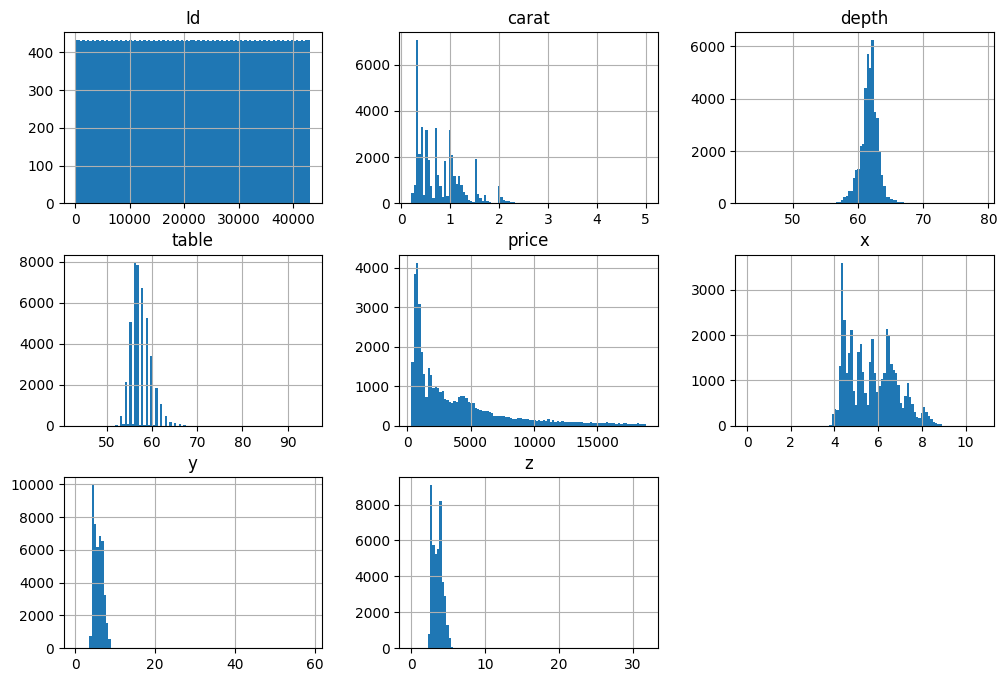

In [11]:
diamonds_train.hist(bins = 100 , figsize=(12,8))
plt.show()

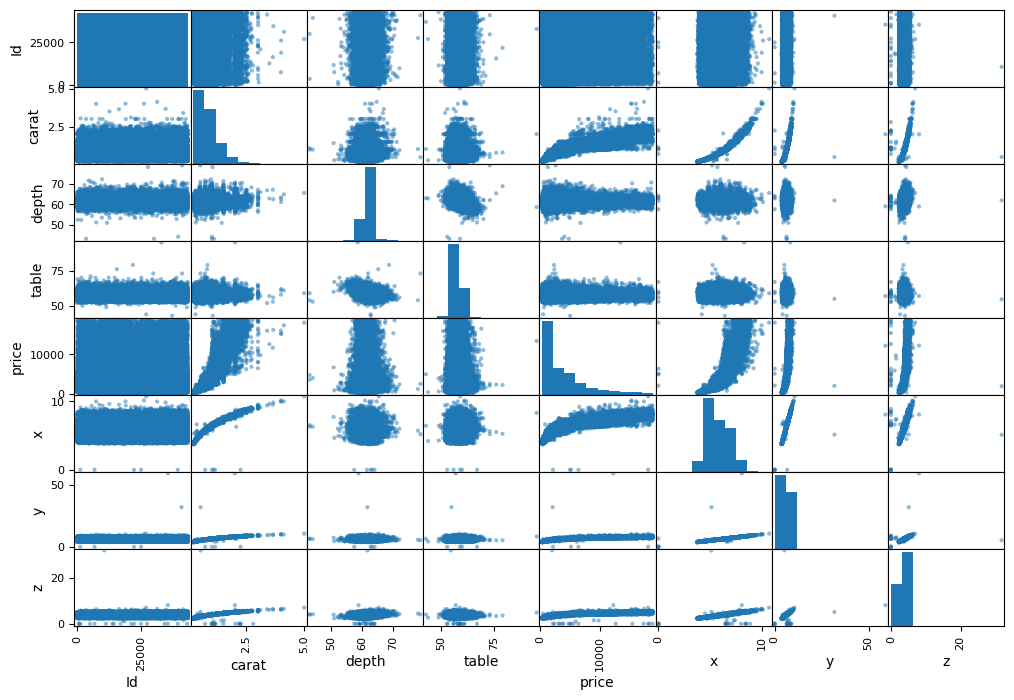

In [12]:
from pandas.plotting import scatter_matrix

scatter_matrix(diamonds_num , figsize=(12,8))
plt.show()

Skewness: 1.6166478300320486


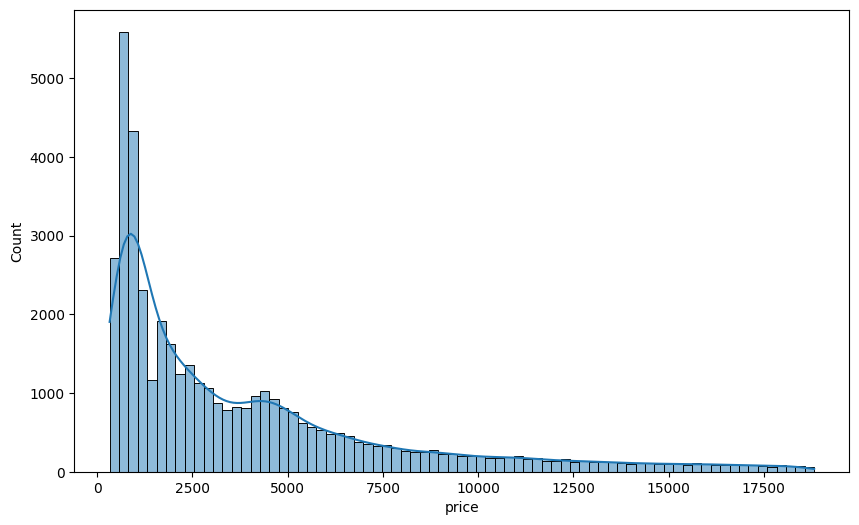

In [14]:
#let's start with target variable price
plt.figure(figsize=(10,6))
#histogram
sns.histplot(diamonds_train['price'],kde=True)
#skewness
print('Skewness:',diamonds_train['price'].skew())
#will deal with it later

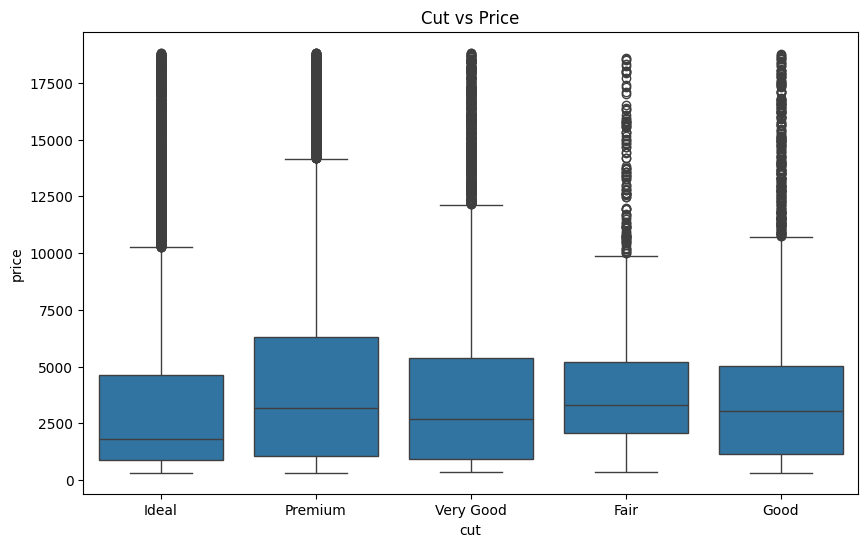

In [15]:
#boxplot
plt.figure(figsize=(10,6))
sns.boxplot(data=diamonds_train,x='cut',y='price')
plt.title('Cut vs Price')
plt.show()

##Handling numerical data.

In [ ]:
diamonds_num.corr()

,Id,carat,depth,table,price,x,y,z
Id,1.000000,0.001141,-0.000776,-0.000739,-0.001111,-0.000519,0.001660,-0.000981
carat,0.001141,1.000000,0.023944,0.182889,0.921911,0.975760,0.947060,0.948923
depth,-0.000776,0.023944,1.000000,-0.302794,-0.013137,-0.029601,-0.033354,0.090834
table,-0.000739,0.182889,-0.302794,1.000000,0.128501,0.197342,0.184310,0.150746
price,-0.001111,0.921911,-0.013137,0.128501,1.000000,0.885181,0.861354,0.857665
x,-0.000519,0.975760,-0.029601,0.197342,0.885181,1.000000,0.968954,0.965677
y,0.001660,0.947060,-0.033354,0.184310,0.861354,0.968954,1.000000,0.942670
z,-0.000981,0.948923,0.090834,0.150746,0.857665,0.965677,0.942670,1.000000


Since the total depth percentage `depth` column is calculated from `x`,`y`,`z` columns, it may seem that `depth` is redundant and we need to ommit it.

 But after looking to the correlation table, we see that `depth` has a low correlation with `x`,`y`,`z` columns, this means there is no redundancy in the information provided.

Although the `x`,`y`,`z` have a high correlation with `price` and the `depth` column has no correlation with `price`.

Hence it seems we need to group all records on `depth` column in clusters.

In [ ]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=5, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # always return self!
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
cluster_simil = ClusterSimilarity(n_clusters=12, gamma=1., random_state=42)
depth = diamonds.depth.to_numpy().reshape(-1,1)

similarities = cluster_simil.fit_transform(depth,
 sample_weight=diamonds_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'ClusterSimilarity' object has no attribute 'kmeans_'

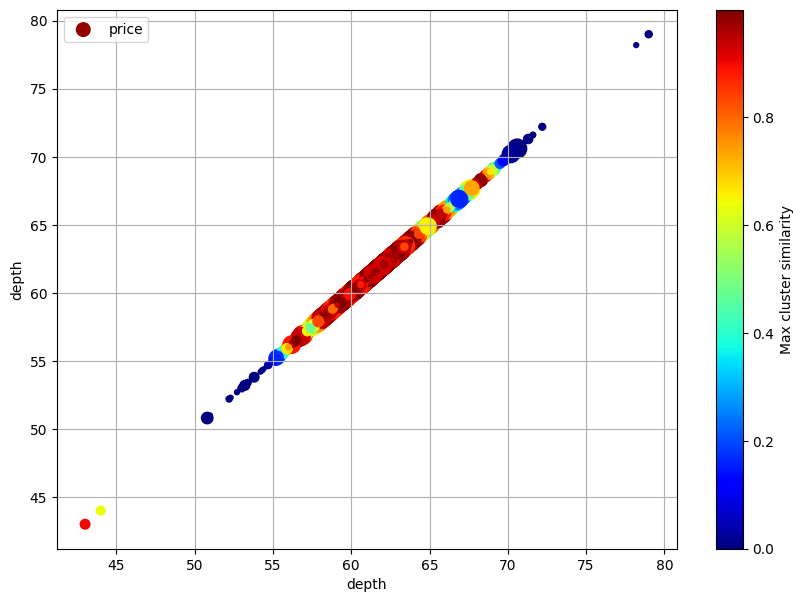

In [ ]:
diamonds_copy = diamonds.copy()
diamonds_copy["Max cluster similarity"] = similarities.max(axis=1)
diamonds_copy.plot(kind="scatter", x="depth", y='depth', grid=True,
                          s=diamonds_labels / 100, label="price",
                          c="Max cluster similarity",
                          cmap="jet", colorbar=True,
                          legend=True, sharex=False, figsize=(10, 7))
plt.plot( cluster_simil.kmeans_.cluster_centers_[:],
          cluster_simil.kmeans_.cluster_centers_[:],
         linestyle="", color="black", marker="X", markersize=8,
         label="Cluster centers")
plt.legend(loc="upper left")
plt.show()

The plot shows the clusters found by the k-means algorithm. We can clearly see that most of the cluster centers are located among the expensive diamonds with a total depth range of approximately [58 - 68].

Now for the rest of the numerical columns,we will use the StandardScaler Transformer

In [ ]:
std_scaler = StandardScaler()
diamonds_num_std_scaled = std_scaler.fit_transform(diamonds_num.drop(['price'],axis=1))

We will build a transformer to claculate the volume feature from x,y and z.

In [ ]:
class VolumeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self , with_volume= True):
        self.with_volume = with_volume

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.with_volume:
            X['volume'] = X['x'] * X['y'] * X['z']
            X.drop(['x','y','z'] ,axis=1 ,inplace = True)
            return X
        else:
            return X


# handling categorical text

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

cats = [
    ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
    sorted(diamonds_cat.color.unique(), reverse=True),
    ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
]
ordinal_encoder = OrdinalEncoder(categories=cats)
diamonds_cat_ordinal = ordinal_encoder.fit_transform(diamonds_cat)
dimonds_cat_ordinal_df = pd.DataFrame(diamonds_cat_ordinal , columns = diamonds_cat.columns.values)
dimonds_cat_ordinal_df.head(2)

,cut,color,clarity
0,4.0,1.0,1.0
1,3.0,3.0,5.0


In [ ]:
diamonds_cat.head(2)

,cut,color,clarity
0,Ideal,I,SI2
1,Premium,G,VVS2


##Making the Pipeline

In [ ]:
volume_attribs = ['x','y','z']
depth_atrrib = ['depth']
num_attribs =['carat', 'table' , 'depth']
cat_attribs = ['cut','color', 'clarity']
cats = [
    ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
    sorted(diamonds_cat.color.unique(), reverse=True),
    ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
]

volume_tranformer = VolumeTransformer()
cluster_simil = ClusterSimilarity(
    n_clusters=5, gamma=1., random_state=42)

num_pipeline = make_pipeline(
        StandardScaler())

cat_pipeline = make_pipeline(
        OrdinalEncoder(categories=cats))

preprocessing = ColumnTransformer([
 ("Volume",  volume_tranformer, volume_attribs),
 ("depth_cluster", cluster_simil, depth_atrrib),
 ("num",        num_pipeline,     num_attribs),
 ("cat",        cat_pipeline,     cat_attribs),
])


##Select and Train the model

In [ ]:
# Linear Regression
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(diamonds, diamonds_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Volume', VolumeTransformer(),
                                                  ['x', 'y', 'z']),
                                                 ('depth_cluster',
                                                  ClusterSimilarity(random_state=42),
                                                  ['depth']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'table', 'depth']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Fair',
                                                                                               'Good',
                                                                                               'Very '
                                                                                               'Good',
                                                                                               'Premium',
                                                                                               'Ideal'],
                                                                                              ['J',
                                                                                               'I',
                                                                                               'H',
                                                                                               'G',
                                                                                               'F',
                                                                                               'E',
                                                                                               'D'],
                                                                                              ['I1',
                                                                                               'SI2',
                                                                                               'SI1',
                                                                                               'VS2',
                                                                                               'VS1',
                                                                                               'VVS2',
                                                                                               'VVS1',
                                                                                               'IF']]))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('linearregression', LinearRegression())])

In [ ]:
lin_pred = lin_reg.predict(diamonds)
predictions = lin_reg.predict(diamonds_test)

lin_mae = mae(diamonds_labels , lin_pred)
lin_mae

850.0962984485684

In [ ]:
# Tree Regression
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor())
tree_reg.fit(diamonds, diamonds_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Volume', VolumeTransformer(),
                                                  ['x', 'y', 'z']),
                                                 ('depth_cluster',
                                                  ClusterSimilarity(random_state=42),
                                                  ['depth']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'table', 'depth']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Fair',
                                                                                               'Good',
                                                                                               'Very '
                                                                                               'Good',
                                                                                               'Premium',
                                                                                               'Ideal'],
                                                                                              ['J',
                                                                                               'I',
                                                                                               'H',
                                                                                               'G',
                                                                                               'F',
                                                                                               'E',
                                                                                               'D'],
                                                                                              ['I1',
                                                                                               'SI2',
                                                                                               'SI1',
                                                                                               'VS2',
                                                                                               'VS1',
                                                                                               'VVS2',
                                                                                               'VVS1',
                                                                                               'IF']]))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [ ]:
preds = tree_reg.predict(diamonds)

predictions = tree_reg.predict(diamonds_test)
tree_mae= mae(diamonds_labels , preds)
tree_mae



13.703397293288843

In [ ]:
# SVM Regression
lin_svm = make_pipeline(preprocessing,
                       LinearSVR(C = 1000,epsilon = 5 ,dual =True ,max_iter=3000))
lin_svm.fit(diamonds ,diamonds_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Volume', VolumeTransformer(),
                                                  ['x', 'y', 'z']),
                                                 ('depth_cluster',
                                                  ClusterSimilarity(random_state=42),
                                                  ['depth']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'table', 'depth']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Fair',
                                                                                               'Good',
                                                                                               'Very '
                                                                                               'Good',
                                                                                               'Premium',
                                                                                               'Ideal'],
                                                                                              ['J',
                                                                                               'I',
                                                                                               'H',
                                                                                               'G',
                                                                                               'F',
                                                                                               'E',
                                                                                               'D'],
                                                                                              ['I1',
                                                                                               'SI2',
                                                                                               'SI1',
                                                                                               'VS2',
                                                                                               'VS1',
                                                                                               'VVS2',
                                                                                               'VVS1',
                                                                                               'IF']]))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('linearsvr', LinearSVR(C=1000, epsilon=5, max_iter=3000))])

In [ ]:
svm_pred = lin_svm.predict(diamonds)
predictions = lin_svm.predict(diamonds)

svm_mae = mae(diamonds_labels ,svm_pred )
svm_mae

824.2465543749394

There is a clear overfitting here.

In [ ]:
# Random Forest Regression
rf_reg = make_pipeline(preprocessing, RandomForestRegressor())
rf_reg.fit(diamonds, diamonds_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Volume', VolumeTransformer(),
                                                  ['x', 'y', 'z']),
                                                 ('depth_cluster',
                                                  ClusterSimilarity(random_state=42),
                                                  ['depth']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'table', 'depth']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Fair',
                                                                                               'Good',
                                                                                               'Very '
                                                                                               'Good',
                                                                                               'Premium',
                                                                                               'Ideal'],
                                                                                              ['J',
                                                                                               'I',
                                                                                               'H',
                                                                                               'G',
                                                                                               'F',
                                                                                               'E',
                                                                                               'D'],
                                                                                              ['I1',
                                                                                               'SI2',
                                                                                               'SI1',
                                                                                               'VS2',
                                                                                               'VS1',
                                                                                               'VVS2',
                                                                                               'VVS1',
                                                                                               'IF']]))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [ ]:
rf_pred = rf_reg.predict(diamonds)
predictions = rf_reg.predict(diamonds_test)

rf_mae = mae(diamonds_labels , rf_pred )
rf_mae

107.07730180947672

In [ ]:
# XGB Regression
xgb_reg = make_pipeline(preprocessing, XGBRegressor())
xgb_reg.fit(diamonds, diamonds_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Volume', VolumeTransformer(),
                                                  ['x', 'y', 'z']),
                                                 ('depth_cluster',
                                                  ClusterSimilarity(random_state=42),
                                                  ['depth']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'table', 'depth']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Fair',
                                                                                               'Good',
                                                                                               'V...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
xgb_pred = xgb_reg.predict(diamonds)

In [ ]:
xgb_mae = mae(diamonds_labels ,xgb_pred )
xgb_mae

228.53507480331382

In [ ]:
predictions = xgb_reg.predict(diamonds_test)

In [ ]:
param_grid = {
    'xgb_regressor__learning_rate': [0.01, 0.02, 0.05],
    'xgb_regressor__n_estimators': [100, 200, 1000,2000,5000],
    'xgb_regressor__max_depth': [8,10 , 13],
    'xgb_regressor__min_child_weight': [1, 3, 5],
    'xgb_regressor__gamma': [0, 0.1, 0.5],
    'xgb_regressor__colsample_bytree': [0.6, 0.8, 1],
    'xgb_regressor__subsample': [0.8, 1],
    'preprocessing__depth_cluster__n_clusters':[8,10,15,17],
    'preprocessing__Volume__with_volume':[True,False]
}


xgb_regressor = Pipeline([('preprocessing' , preprocessing),
                             ('xgb_regressor',  XGBRegressor())])

random_search = RandomizedSearchCV(estimator=xgb_regressor,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error',
                                   cv=5)

random_search.fit(diamonds, diamonds_labels)

print("Best Hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_

y_pred = best_model.predict(diamonds)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

KeyboardInterrupt: 

In [ ]:
MAE = mae(diamonds_labels, y_pred)
print("mean absolute error:", MAE)

In [ ]:
predictions = best_model.predict(diamonds_test)

In [ ]:
diamonds_test = pd.read_csv(Path('test.csv'))

submissions = diamonds_test[['Id']]

submissions['price'] = predictions

submissions.to_csv('submissions.csv' , index=False)